<a href="https://colab.research.google.com/github/plaban1981/Langchain_usecases/blob/main/Retrieval_Augmented_Generation_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip  install -qU openai langchain PyPDF2 transformers tiktoken pinecone-client sentence-transformers qdrant-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.0 MB/s eta 0:00:00


## Packages for scanned documents

In [2]:
!apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 9 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,751 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 120493 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-e

In [3]:
! apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 9 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.1 [186 kB]
Fetched 186 kB in 1s (363 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 120540 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.1_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.1) ...
Setting up poppler-utils (22.02.0-2ubuntu0.1) ...
Processing triggers for man-db (2.10.2-1) ...


In [4]:
! pip install -U pytesseract

In [5]:
! pip install pdf2image

In [ ]:
import PyPDF2
from PyPDF2 import PdfReader
import io
import pytesseract
import shutil
import random
from PIL import Image
from pdf2image import convert_from_path

In [6]:
!wget "https://content.accion.org/wp-content/uploads/2018/08/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf"

--2023-07-30 03:38:49--  https://content.accion.org/wp-content/uploads/2018/08/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf
Resolving content.accion.org (content.accion.org)... 151.101.194.159
Connecting to content.accion.org (content.accion.org)|151.101.194.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 724217 (707K) [application/pdf]
Saving to: ‘Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf’

Employee-Stock-Opti 100%[===================>] 707.24K  --.-KB/s    in 0.02s   

2023-07-30 03:38:49 (30.6 MB/s) - ‘Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf’ saved [724217/724217]



In [ ]:
def is_scanned_pdf(file_path):
    page_num  = []
    page_content = []
    pdf_reader = PdfReader(file_path)
    text = ""
    for i,page in enumerate(pdf_reader.pages):
      page_num.append(f"Page{i+1}")
      page_content.append(page.extract_text())
      text += page.extract_text()

    # if no text found, it is likely a scanned pdf
    if text == "":
        print("Scanned PDF")
        return True,page_num,page_content

    else:
        print("Text-based PDF")
        return False,page_num,page_content

In [ ]:
file_path = "/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf"
flag,page_num,page_content = is_scanned_pdf(file_path)

Text-based PDF


In [ ]:
len(page_num),len(page_content)

(44, 44)

In [ ]:
page_content[:5]

['Startup Employee Stock \nOptions Plans (ESOPs)  \n \nOverview and Best Practices  \n',
 'Table of Contents  \nPart I: Intro to Options Plans  \n•What is an ESOP?  \n•What is an Option?  \n•Lifecycle of a Startup ESOP  \n•Common Terms in an Options Package  \n•Why Issue Options to Employees ? \n–A Defining Characteristic of Startup Culture  \n–A Necessary Part of the Capital Structure  \n•When to Create an ESOP ? \n•Communicating Options to Employees: % versus $ \n \nPart II: How Much to Grant  \n•Two Approaches  \n•The Top -Down Process  \n–1. How Much Equity to Set Aside in the ESOP ? \n–2. A Typical Distribution Schedule  \n•The Bottom -Up Process  \n–1. Segment Your Human Resources  \n–2. Establish Pay Multipliers for Each Role \n–3. Determine the Dollar Value of the Options Grant  \n–4. Determine the Current Share Price  \n–5. Calculate the Options Grant  \n–An Example: Hiring a CTO  \n•Important Takeaways  Part III : The Fine Print – Terms  \n•Strike Price  \n•Vesting Schedule  

In [ ]:
! pip install -U sentence_transformers

In [ ]:
import sentence_transformers

In [ ]:
sentence_transformers.__version__

'2.2.2'

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings()
doc_result = embeddings.embed_documents([page_content[1]])

In [ ]:
embeddings

HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
), model_name='sentence-transformers/all-mpnet-base-v2', cache_folder=None, model_kwargs={}, encode_kwargs={})

In [ ]:
doc_result = embeddings.embed_documents(page_content)

In [ ]:
len(doc_result)

44

In [ ]:
len(doc_result[0]),len(doc_result[1])

(768, 768)

In [ ]:
import openai
from getpass import getpass
import os
os.environ["OPENAI_API_KEY"] =getpass()

··········


## VectorDatabase

In [ ]:
index_name = 'langchain-retrieval-augmentation'

In [ ]:
os.environ["PINECONE_API_KEY"] = getpass()

··········


In [ ]:
os.environ["PINECONE_ENVIRONMENT"] = "us-west1-gcp"

In [ ]:
import pinecone

# find API key in console at app.pinecone.io
PINECONE_API_KEY = os.getenv('PINECONE_API_KEY')
# find ENV (cloud region) next to API key in console
PINECONE_ENVIRONMENT = os.getenv('PINECONE_ENVIRONMENT')

pinecone.init(
    api_key=PINECONE_API_KEY ,
    environment=PINECONE_ENVIRONMENT,
)

if index_name not in pinecone.list_indexes():
    # we create a new index
    pinecone.create_index(
        name=index_name,
        metric='cosine',
        dimension=len(doc_result[0])  # 768
    )

## Connect to Index

In [ ]:
index = pinecone.Index(index_name)

index.describe_index_stats()

{'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [ ]:
page_num[0]

'Page1'

In [ ]:
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')

# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

tiktoken_len(page_content[1])

310

## Populate the vector database with huggingface embedings

* We can perform the indexing task using the LangChain vector store object. But for now it is much faster to do it via the Pinecone python client directly. We will do this in batches of 10

In [ ]:
from tqdm.auto import tqdm
from uuid import uuid4
from langchain.text_splitter import RecursiveCharacterTextSplitter
batch_limit = 100

texts = []
metadatas = []
#
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=tiktoken_len,
    separators=["\n\n", "\n", " ", ""]
)

for p,record in tqdm(zip(page_num,page_content)):
    # first get metadata fields for this record
    metadata = {'page number': p}
    # now we create chunks from the record text
    record_texts = text_splitter.split_text(record)
    # create individual metadata dicts for each chunk
    record_metadatas = [{
        "chunk": j, "text": text, **metadata
    } for j, text in enumerate(record_texts)]
    # append these to current batches
    texts.extend(record_texts)
    metadatas.extend(record_metadatas)
    # if we have reached the batch_limit we can add texts
    if len(texts) >= batch_limit:
        ids = [str(uuid4()) for _ in range(len(texts))]
        embeds = embeddings.embed_documents(texts)
        index.upsert(vectors=zip(ids, embeds, metadatas))
        texts = []
        metadatas = []

if len(texts) > 0:
    ids = [str(uuid4()) for _ in range(len(texts))]
    embeds = embeddings.embed_documents(texts)
    index.upsert(vectors=zip(ids, embeds, metadatas))

0it [00:00, ?it/s]

In [ ]:
index.describe_index_stats()

{'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 44}},
 'total_vector_count': 44}

In [ ]:
query = "What is an ESOP?"
xq = embeddings.embed_documents([query])
response = index.query(xq,top_k=1, include_metadata=True)
print(response['matches'][0]['metadata']['page number'])
print(response['matches'][0]['metadata']['text'])

Page4
What is an ESOP?  
•An Employee Stock Options Plan (ESOP)  
 
•An allocation  of shares that will be granted to employees in the future 
in the form of stock options  
–How much equity should we set aside for employees?  
 
•A plan for how these options will be distributed:  
–How many shares will individual employees receive?  
–What terms will govern these grants?  
 
•The plan is as important as the allocation!


In [ ]:
print(response['matches'][1]['metadata']['page number'])
print(response['matches'][1]['metadata']['text'])

Page14
Two Approaches  
In reality, creating an ESOP will require a combination of 
top-down and bottom -up planning  Top Down  Bottom Up  
Decide the total amount of 
equity to be granted; allocate 
these shares to employees 
over time  Decide the appropriate size of 
individual equity grants by 
position; issue these shares as 
employees are hired


In [ ]:
print(response['matches'][2]['metadata']['page number'])
print(response['matches'][2]['metadata']['text'])

Page35
ESOPS FOR THE LONG TERM  Part IV


In [ ]:
response

{'matches': [{'id': '2486fbd3-1ab1-4d00-8be9-6c71679c46cc',
              'metadata': {'chunk': 0.0,
                           'page number': 'Page4',
                           'text': 'What is an ESOP?  \n'
                                   '•An Employee Stock Options Plan (ESOP)  \n'
                                   ' \n'
                                   '•An allocation  of shares that will be '
                                   'granted to employees in the future \n'
                                   'in the form of stock options  \n'
                                   '–How much equity should we set aside for '
                                   'employees?  \n'
                                   ' \n'
                                   '•A plan for how these options will be '
                                   'distributed:  \n'
                                   '–How many shares will individual employees '
                                   'receive?  \n'
              

## Generative Question-Answering
In GQA we take the query as a question that is to be answered by a LLM, but the LLM must answer the question based on the information it is seeing being returned from the vectorstore.

To do this we initialize a RetrievalQA object like so:

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.chains import RetrievalQAWithSourcesChain

In [ ]:
# completion llm
llm = ChatOpenAI(
    openai_api_key=os.environ["OPENAI_API_KEY"],
    model_name='gpt-3.5-turbo',
    temperature=0.0
)

In [ ]:
from langchain.vectorstores import Pinecone

text_field = "text"

# switch back to normal index for langchain
index = pinecone.Index(index_name)

vectorstore = Pinecone(
    index, embeddings.embed_query, text_field
)

In [ ]:
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever(),
)

In [ ]:
qa(query)

{'query': 'What is an ESOP?',
 'result': 'An ESOP, or Employee Stock Options Plan, is a program that allows employees to receive shares of company stock in the form of stock options. It involves allocating a certain amount of equity to be granted to employees in the future. The plan also includes determining how many shares each employee will receive and the terms that will govern these grants. It is important to seek legal advice from an experienced startup lawyer when structuring an ESOP.'}

In [ ]:
qa_with_sources = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever()
)

In [ ]:
qa_with_sources(query)

ValueError: ignored

## Langchain with Qdrant

## Qdrant Metadata
Qdrant stores your vector embeddings along with the optional JSON-like payload. Payloads are optional, but since LangChain assumes the embeddings are generated from the documents, we keep the context data, so you can extract the original texts as well.

By default, your document is going to be stored in the following payload structure:
```
{
    "page_content": "Lorem ipsum dolor sit amet",
    "metadata": {
        "foo": "bar"
    }
}
```

In [ ]:
from qdrant_client import models, QdrantClient

## Define storage location

In [ ]:
qdrant = QdrantClient(":memory:")

## Create a collection

In [ ]:
qdrant.recreate_collection(
	collection_name="langchain-retrieval-augmentation",
	vectors_config=models.VectorParams(
		size=len(doc_result[0]), # Vector size is defined by used model
		distance=models.Distance.COSINE
	)
)

True

In [ ]:
type(doc_result)

list

In [ ]:
index_name = 'langchain-retrieval-augmentation'

In [ ]:
from tqdm.auto import tqdm
from uuid import uuid4
from langchain.text_splitter import RecursiveCharacterTextSplitter
batch_limit = 10

texts = []
metadatas = []
#
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    separators=["\n\n", "\n", " ", ""]
)

for p,record in tqdm(zip(page_num,page_content)):
    # first get metadata fields for this record
    metadata = {'page number': p}
    # now we create chunks from the record text
    record_texts = text_splitter.split_text(record)
    # create individual metadata dicts for each chunk
    record_metadatas = [{
        "chunk": j, "text": text, **metadata
    } for j, text in enumerate(record_texts)]
    # append these to current batches
    texts.extend(record_texts)
    metadatas.extend(record_metadatas)
    # if we have reached the batch_limit we can add texts
    if len(texts) >= batch_limit:
        ids = [str(uuid4()) for _ in range(len(texts))]
        embeds = embeddings.embed_documents(texts)
        qdrant.upsert(
        collection_name=index_name,
        points=models.Batch(ids=ids, vectors=embeds, payloads=metadatas),
        )
        texts = []
        metadatas = []

if len(texts) > 0:
    ids = [str(uuid4()) for _ in range(len(texts))]
    embeds = embeddings.embed_documents(texts)
    qdrant.upsert(
        collection_name=index_name,
        points=models.Batch(ids=ids, vectors=embeds, payloads=metadatas),
        )

0it [00:00, ?it/s]

In [ ]:
query = "What are the Common Terms in an Options Package?"
xq = embeddings.embed_documents([query])

In [ ]:
type(xq)

list

In [ ]:
collections = qdrant.get_collections()
print(collections)

collections=[CollectionDescription(name='langchain-retrieval-augmentation')]


In [ ]:
collection_vector_count = qdrant.get_collection(collection_name=index_name).vectors_count
print(f"Vector count in collection: {collection_vector_count}")

Vector count in collection: 50


In [ ]:
type(xq)

list

In [ ]:
def get_match(query_embed):
  result = qdrant.search(
            collection_name=index_name,
            query_vector=query_embed[0],
            limit=1,
            with_vectors=True,
            with_payload=True,
        )
  #print(result)
  context = [[x.payload["text"], x.payload["page number"]] for x in result]
  #print(context)
  response = {"text":context[0][0],"page_number":context[0][1]}
  return response

## Query1

In [ ]:
query = "What are the Common Terms in an Options Package?'"
xq = embeddings.embed_documents([query])
get_match(xq)

{'text': 'Common Terms in an Options Package  \nNumber of Shares  The total number of  options granted to an \nemployee, and therefore the maximum number of \nshares that employee has access to   \nStrike Price  The price the  employee must pay to purchase \neach share if and when the employee chooses to \nexercise the option  \nVesting  Schedule  The timeline over which the options become \nwholly owned and exercisable  by the employee \n(no longer subject to repurchase by the company)  \nCliff Period  The trial  period during which no vesting occurs; in \nthis period vesting accrues, but the total effect of \nthis vesting is realized immediately after the cliff  \nExpiration Date  The last date on which the options  may be \nexercised and converted into common shares by \nthe employee  \nWe will discuss the mechanics in further detail, but these basic \nterms are helpful to understanding options grants',
 'page_number': 'Page7'}

## query = 2

In [ ]:
query = "How do startups use options?"
xq = embeddings.embed_documents([query])
get_match(xq)

{'text': 'What is an Option?  \n•Why do options have intrinsic value?  \n–A effective form of equity ownership  \n–A locked -in price for shares  \n•How do startups use options?  \n–To bring in founding team members \nwho are not co -founders  \n–To recruit, compensate and retain \nearly employees  \n–To allow later employees to share in \nthe company’s long -term upside  Terminology:   \nThis presentation uses “options” \ngenerally to refer to several types of \nsecurities that are often issued to startup \nemployees to provide for effective equity \nownership, including:  \n-Stock options (the right to buy \ncommon stock a set strike price)  \n-Restricted stock (common stock \nissued early on to top employees)  \n-Restricted stock units (a promise to \nissue common stock in the future)  \nAppropriate use of these securities will \nvary based on local regulatory and tax \nconsiderations.  An option is a right (but not an obligation) to purchase a quantity',
 'page_number': 'Page5'}

In [ ]:
query = "What is an options?"
xq = embeddings.embed_documents([query])
get_match(xq)

{'text': 'Appropriate use of these securities will \nvary based on local regulatory and tax \nconsiderations.  An option is a right (but not an obligation) to purchase a quantity \nof a company’s stock at a set price for a certain period of time',
 'page_number': 'Page5'}

## Final Inference Script

In [ ]:
import os
os.mkdir("db")

In [ ]:
!pip install -qU transformers

In [ ]:
from qdrant_client import models, QdrantClient
from langchain.embeddings import HuggingFaceEmbeddings
import PyPDF2
from PyPDF2 import PdfReader
from tqdm.auto import tqdm
from uuid import uuid4
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from time import time,sleep
#
import os
import json
#
import io
import pytesseract
import shutil
import random
from PIL import Image
from pdf2image import convert_from_path

#
def is_scanned_pdf(file_path):
    page_num  = []
    page_content = []
    pdf_reader = PdfReader(file_path)
    text = ""
    for i,page in enumerate(pdf_reader.pages):
      page_num.append(f"Page{i+1}")
      page_content.append(page.extract_text())
      text += page.extract_text()

    # if no text found, it is likely a scanned pdf
    if text == "":
        print("Scanned PDF")
        return True,page_num,page_content

    else:
        print("Text-based PDF")
        return False,page_num,page_content
#
def convert_pdf_to_image(pdf_path):
    pages = convert_from_path(pdf_path, 350)
    #
    output_dir="pdf_img_dir"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    i = 1
    for page in pages:
        image_name = "Page_" + str(i) + ".jpg"
        image_path = os.path.join(output_dir,image_name)
        page.save(image_path, "JPEG")
        i = i+1
    return output_dir

# Extract text from image
#
def extract_text_from_image(image_path):
    extractedInformation = pytesseract.image_to_string(Image.open(image_path))
    return extractedInformation
#
#
def Upsert_collection(qdrant,page_num,page_content,index_name,embeddings):
    texts = []
    metadatas = []
    if len(page_num) <= 10:
      batch_limit = 1
    elif (len(page_num) > 10) and (len(page_num) < 50):
      batch_limit = 10
    elif (len(page_num) > 50) and (len(page_num) < 200):
      batch_limit = 25
    else :
      batch_limit = 50

    for p,record in tqdm(zip(page_num,page_content)):
      # first get metadata fields for this record
      metadata = {'page number': p}
      # now we create chunks from the record text
      record_texts = get_text_chunks(record)
      # create individual metadata dicts for each chunk
      record_metadatas = [{
          "chunk": j, "text": text, **metadata
      } for j, text in enumerate(record_texts)]
      # append these to current batches
      texts.extend(record_texts)
      metadatas.extend(record_metadatas)

      if len(texts) >= batch_limit:
          #print(texts)
          #print(metadatas)
          #
          ids = [str(uuid4()) for _ in range(len(texts))]
          embeds = embeddings.embed_documents(texts)

          qdrant.upsert(
          collection_name=index_name,
          points=models.Batch(ids=ids, vectors=embeds, payloads=metadatas),
          )
          texts = []
          metadatas = []

    if len(texts) > 0:
        ids = [str(uuid4()) for _ in range(len(texts))]
        embeds = embeddings.embed_documents(texts)
        qdrant.upsert(
            collection_name=index_name,
            points=models.Batch(ids=ids, vectors=embeds, payloads=metadatas),
            )
    collection_vector_count = qdrant.get_collection(collection_name=index_name).vectors_count
    print(f"Vector count in collection: {collection_vector_count}")

#

#
def get_text_chunks(text):
    text_splitter = RecursiveCharacterTextSplitter(
                            chunk_size=1000,
                            chunk_overlap=200,
                            separators=["\n\n", "\n", " ", ""]
                            )
    chunks = text_splitter.split_text(text)
    return chunks
#
def preprocess_function(request_data,content_type=None):
  pdf_docs = request_data["pdf1"]
  prompt = request_data["query"]
  flag,page_num,page_content = is_scanned_pdf(pdf_docs)
  pdf_name = "temppdf"
  f_path = os.path.join("/tmp", pdf_name)
  #
  if flag:
    #with open(f_path, "wb") as f:
    #  f.write(pdf_docs.getbuffer())
    #print(f"filesize : {os.path.getsize(f_path)}")
    page_num  = []
    page_content = []
    text = ""
    f_path = pdf_docs
    image_dir = convert_pdf_to_image(f_path)
    for i,file in enumerate(os.listdir(image_dir)):
      page_num.append(f"Page{i+1}")
      image_path = os.path.join(image_dir,file)
      page_content.append(extract_text_from_image(image_path))
      text += extract_text_from_image(image_path)
      print(f"Text read from image: {text}")

  return (flag,page_num,page_content,prompt)
#
def model_load_function(content):
  flag,page_num,page_content,prompt = content
  embeddings = HuggingFaceEmbeddings()
  return embeddings
#
def predict_function(context,model, content_type=None):
    embeddings = model
    flag,page_num,page_content,prompt = context

    print(len(page_num),len(page_content))
    print(prompt)
    #qdrant = QdrantClient(path ="/content/db")
    qdrant = QdrantClient(":memory:")
    collection_name = "DOC_Search"
    collections = qdrant.get_collections()
    print(collections)
    #qdrant = QdrantClient(path ="/content/db")
    doc_embed = embeddings.embed_documents(page_content[0])
    print(doc_embed)
    print(len(doc_embed[0]))
    # only create collection if it doesn't exist
    if collection_name not in collections:
          qdrant.recreate_collection(
              collection_name=collection_name,
              vectors_config=models.VectorParams(
                  size=len(doc_embed[0]),
                  distance=models.Distance.COSINE,
              ),
          )
    collections = qdrant.get_collections()
    print(collections)
    # insert records into vectorstore
    Upsert_collection(qdrant,page_num,page_content,collection_name,embeddings)
    #
    collection_vector_count = qdrant.get_collection(collection_name=collection_name).vectors_count
    print(f"Vector count in collection: {collection_vector_count}")
    # Get Similar records
    query_embed = embeddings.embed_documents([prompt])
    print(query_embed)
    result = qdrant.search(
            collection_name=collection_name,
            query_vector=query_embed[0],
            limit=3,
            with_payload=True,
            search_params=models.SearchParams(
        hnsw_ef=128,
        exact=False
    ),
        )
    print(result)
    context = [[x.payload["text"], x.payload["page number"]] for x in result]
    print(context)
    t = []
    pg = []
    s = []
    for items in context:
      print(items)

    response = {"text":context[0][0],"page_number":context[0][1]}
    #
    qdrant.delete_collection(collection_name="Doc_Search")
    return response
#
def postprocess_function(predictions, content_type=None):
  return json.dumps({"response": predictions})






In [ ]:
request_data = {"pdf1":"/content/trade.pdf",
                "query":"Will interest be charged if the amount is not paid within due date?"}
content = preprocess_function(request_data,content_type=None)

Scanned PDF
Text read from image: ij

@ KEYTRADE ORIGINAL

Buyer:
GOULDING CHEMICALS LTD.,
CENTRE PARK ROAD,

MARINA, CORK
SWITZERLAND IRELAND
VAT NO: NL822947778B01 VAT NO: IE8Z56076R

 

COMMERCIAL INVOICE NO: 0000448 DATE: 28 March 2018
NO. NUMBER CODE NAME NO TERMS
CELINA
201710299 FREE

Description of Goods QUANTITY UNIT PRICE AMOUNT

(Metric Tons)! (EUR Per MT) (EUR)

  
 

    

GRANULAR CALCIUM AMMONIUM NITRATE (CAN) 27 % IN BULK

5'476.100 183.00 4'002'126.30
CIF FOYNES

TOTAL AMOUNT CIF FOYNES, IRELAND, EUR 4'002'126.30

VAT ZERO RATE IN CONFORMITY WITH ARTICLE 141 EC DIRECTIVE 2006/112

TOTAL VAT RATE VAT AMOUNT EUR TOTAL oe

PAYMENT: BY TT WITHIN 90 DAYS FROM BIL DATE (28.03.2018), I.E. LATEST BY 26 JUNE 2018

 

Shipment details:

PORT OF LOADING : KLAIPEDA, LITHUANIA
PORT OF DISCHARGE: FOYNES, IRELAND

BILL OF LADING : 5'476.100 METRIC TONS
BILL OF LADING NO. 1
BILL OF LADING DATE: 28 March 2018

ORIGIN: LITHUANIA

Unless otherwise provided in the sales contract or agreed

In [ ]:
flag,page_num,page_content,prompt = content

In [ ]:
len(page_num),len(page_content)

(1, 1)

In [ ]:
request_data = {"pdf1":"/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf",
                "query":"Why Issue Options to Employees?"}
content = preprocess_function(request_data,content_type=None)

Text-based PDF
collections=[CollectionDescription(name='DOC_Search')]
768
collections=[CollectionDescription(name='DOC_Search')]


In [ ]:
model_load_function(content)

HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
), model_name='sentence-transformers/all-mpnet-base-v2', cache_folder=None, model_kwargs={}, encode_kwargs={})

In [ ]:
model = model_load_function(content)


In [ ]:
response = predict_function(content,model, content_type=None)

1 1
Will interest be charged if the amount is not paid within due date?
collections=[]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0it [00:00, ?it/s]

Vector count in collection: 2
Vector count in collection: 2
[[0.02206660993397236, -0.0353192463517189, 0.011373501271009445, -0.027146635577082634, -0.002202652394771576, 0.03277724236249924, 0.05897736921906471, -0.008239415474236012, 0.0007316850824281573, 0.03801165148615837, 0.043808307498693466, 0.026091687381267548, 0.010354757308959961, -0.03132372722029686, -0.00912400707602501, 0.05384654924273491, 0.024481190368533134, -0.010559437796473503, 0.03301302343606949, -0.013390344567596912, -0.059536777436733246, 0.04444413259625435, -0.06473233550786972, -0.03266296535730362, -0.010130748152732849, -0.01265908032655716, -0.07600044459104538, -0.03248683363199234, 0.029863525182008743, 0.0013414041604846716, 0.006890547927469015, -0.01935729943215847, -0.026337819173932076, 0.025879869237542152, 9.881160849545267e-07, -0.023567311465740204, 0.02319829724729061, 0.00043093811837024987, -0.0017402874073013663, 0.08678232133388519, -0.029855243861675262, 0.016800880432128906, 0.00152

In [ ]:
response = predict_function(content,model, content_type=None)

1 1
Will interest be charged if the amount is not paid within due date?
collections=[]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0it [00:00, ?it/s]

Vector count in collection: 2
Vector count in collection: 2
[[0.02206660993397236, -0.0353192463517189, 0.011373501271009445, -0.027146635577082634, -0.002202652394771576, 0.03277724236249924, 0.05897736921906471, -0.008239415474236012, 0.0007316850824281573, 0.03801165148615837, 0.043808307498693466, 0.026091687381267548, 0.010354757308959961, -0.03132372722029686, -0.00912400707602501, 0.05384654924273491, 0.024481190368533134, -0.010559437796473503, 0.03301302343606949, -0.013390344567596912, -0.059536777436733246, 0.04444413259625435, -0.06473233550786972, -0.03266296535730362, -0.010130748152732849, -0.01265908032655716, -0.07600044459104538, -0.03248683363199234, 0.029863525182008743, 0.0013414041604846716, 0.006890547927469015, -0.01935729943215847, -0.026337819173932076, 0.025879869237542152, 9.881160849545267e-07, -0.023567311465740204, 0.02319829724729061, 0.00043093811837024987, -0.0017402874073013663, 0.08678232133388519, -0.029855243861675262, 0.016800880432128906, 0.00152

In [ ]:
response = predict_function(content,model, content_type=None)

44 44
What are the Common Terms in an Options Package?
collections=[CollectionDescription(name='DOC_Search')]


0it [00:00, ?it/s]

['Startup Employee Stock \nOptions Plans (ESOPs)  \n \nOverview and Best Practices', 'Table of Contents  \nPart I: Intro to Options Plans  \n•What is an ESOP?  \n•What is an Option?  \n•Lifecycle of a Startup ESOP  \n•Common Terms in an Options Package  \n•Why Issue Options to Employees ? \n–A Defining Characteristic of Startup Culture  \n–A Necessary Part of the Capital Structure  \n•When to Create an ESOP ? \n•Communicating Options to Employees: % versus $ \n \nPart II: How Much to Grant  \n•Two Approaches  \n•The Top -Down Process  \n–1. How Much Equity to Set Aside in the ESOP ? \n–2. A Typical Distribution Schedule  \n•The Bottom -Up Process  \n–1. Segment Your Human Resources  \n–2. Establish Pay Multipliers for Each Role \n–3. Determine the Dollar Value of the Options Grant  \n–4. Determine the Current Share Price  \n–5. Calculate the Options Grant  \n–An Example: Hiring a CTO  \n•Important Takeaways  Part III : The Fine Print – Terms  \n•Strike Price  \n•Vesting Schedule  \n•Th

In [ ]:
response = predict_function(content,model, content_type=None)

44 44
Why Issue Options to Employees?
collections=[CollectionDescription(name='DOC_Search')]


0it [00:00, ?it/s]

['Startup Employee Stock \nOptions Plans (ESOPs)  \n \nOverview and Best Practices', 'Table of Contents  \nPart I: Intro to Options Plans  \n•What is an ESOP?  \n•What is an Option?  \n•Lifecycle of a Startup ESOP  \n•Common Terms in an Options Package  \n•Why Issue Options to Employees ? \n–A Defining Characteristic of Startup Culture  \n–A Necessary Part of the Capital Structure  \n•When to Create an ESOP ? \n•Communicating Options to Employees: % versus $ \n \nPart II: How Much to Grant  \n•Two Approaches  \n•The Top -Down Process  \n–1. How Much Equity to Set Aside in the ESOP ? \n–2. A Typical Distribution Schedule  \n•The Bottom -Up Process  \n–1. Segment Your Human Resources  \n–2. Establish Pay Multipliers for Each Role \n–3. Determine the Dollar Value of the Options Grant  \n–4. Determine the Current Share Price  \n–5. Calculate the Options Grant  \n–An Example: Hiring a CTO  \n•Important Takeaways  Part III : The Fine Print – Terms  \n•Strike Price  \n•Vesting Schedule  \n•Th

In [ ]:
postprocess_function(response, content_type=None)

'{"response": {"text": "PORT OF LOADING : KLAIPEDA, LITHUANIA\\nPORT OF DISCHARGE: FOYNES, IRELAND\\n\\nBILL OF LADING : 5\'476.100 METRIC TONS\\nBILL OF LADING NO. 1\\nBILL OF LADING DATE: 28 March 2018\\n\\nORIGIN: LITHUANIA\\n\\nUnless otherwise provided in the sales contract or agreed to in writing, the amount IRENEFICIARY\'S BANK DETAILS:\\n\\nshown on this invoice is to be pald on or before due date by Telegraphic Transfer of | CREDIT EUROPE BANK N.V\\n\\nimmediately available funds. \\u201c\\n\\ninterest will be charged for any amounts not paid within the term of this invoice. | SWIFT: FBHLNLZAXXX\\n\\nThis invoice is subject to the terms and conditions |KEYTRADE AG EUR ACCOUNT: 07813 17 614\\n\\nset forth in KEYTRADE AG\'s sales contract. IBAN NO: NL45 FBHL 0781 3176 14\\n\\nmeray te ACY\\nZURCHEROTRA 3 Ari\\n\'\\n\\nwit, oy\\nHoo9e\\u00a2\\n\\nee ms\\nVAT tia ae NLELLOS", "page_number": "Page1"}}'

In [ ]:
qdrant.delete_collection(collection_name="Doc_Search")

NameError: ignored

## Using Langchain + Qdrant for Question Answering.

In [ ]:
from langchain import VectorDBQA
from getpass import getpass
import os
os.environ["OPENAI_API_KEY"] = getpass()

··········


In [ ]:
metadatas = []
for p,record in tqdm(zip(page_num,page_content)):
      # first get metadata fields for this record
      metadata = {'page number': p}
      # now we create chunks from the record text
      record_texts = get_text_chunks(record)
      # create individual metadata dicts for each chunk
      record_metadatas = [{
          "chunk": j, "text": text, **metadata
      } for j, text in enumerate(record_texts)]
      # append these to current batches
      texts.extend(record_texts)
      metadatas.extend(record_metadatas)

0it [00:00, ?it/s]

## Qdrant Vectorstore - Cloud

In [ ]:
from langchain.vectorstores.qdrant import Qdrant
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(openai_api_key=os.environ["OPENAI_API_KEY"],temperature=0)
doc_store = Qdrant.from_texts(page_content,
                              metadatas=metadatas,
                              embedding=embeddings,
                              api_key="crjy1brG_LtCyAMKBsK8ni2bLIZl_NPfo9fB7x6vInwYRnsTtXmr0A",
                              url="https://f2d7092d-7da3-4b40-a8bf-41caebc0558f.us-east-1-0.aws.cloud.qdrant.io:6333")

In [ ]:
from langchain.llms import OpenAI
llm = OpenAI(openai_api_key=os.environ["OPENAI_API_KEY"],temperature=0)

In [ ]:
llm = ChatOpenAI(openai_api_key=os.environ["OPENAI_API_KEY"],temperature=0)

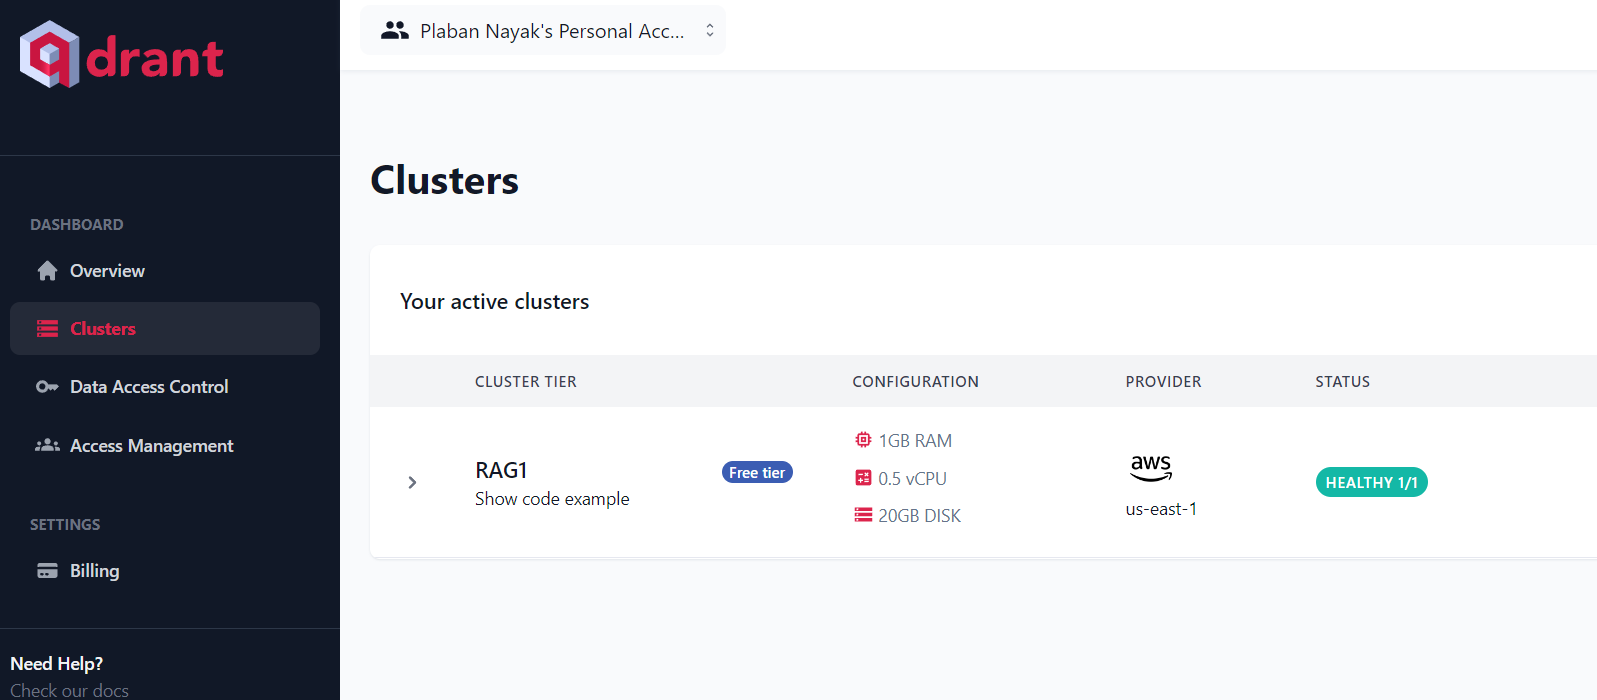

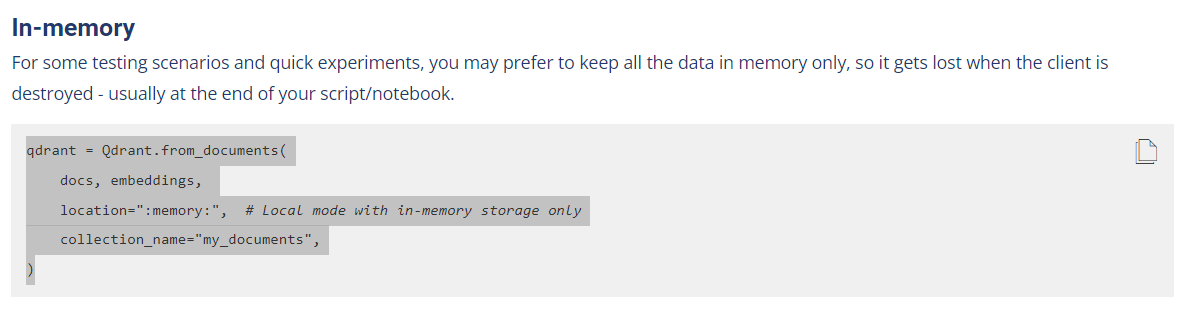

In [ ]:
doc_store = Qdrant.from_texts(page_content,
                              metadatas=metadatas,
                              embedding=embeddings,
                              location=":memory:",
                              collection="doc_search")

In [ ]:
qa = VectorDBQA.from_chain_type(llm=llm,
                                chain_type="stuff",
                                vectorstore=doc_store,
                                return_source_documents=True)

/usr/local/lib/python3.10/dist-packages/langchain/chains/retrieval_qa/base.py:245: UserWarning: `VectorDBQA` is deprecated - please use `from langchain.chains import RetrievalQA`
  warnings.warn(


In [ ]:
result = qa("What are the Common Terms in an Options Package?")

In [ ]:
result

{'query': 'What are the Common Terms in an Options Package?',
 'result': 'The common terms in an options package include the number of shares, strike price, vesting schedule, cliff period, and expiration date.',
 'source_documents': [Document(page_content='Common Terms in an Options Package  \nNumber of Shares  The total number of  options granted to an \nemployee, and therefore the maximum number of \nshares that employee has access to   \nStrike Price  The price the  employee must pay to purchase \neach share if and when the employee chooses to \nexercise the option  \nVesting  Schedule  The timeline over which the options become \nwholly owned and exercisable  by the employee \n(no longer subject to repurchase by the company)  \nCliff Period  The trial  period during which no vesting occurs; in \nthis period vesting accrues, but the total effect of \nthis vesting is realized immediately after the cliff  \nExpiration Date  The last date on which the options  may be \nexercised and co

In [ ]:
result['query']

'What are the Common Terms in an Options Package?'

In [ ]:
result['result']

'The common terms in an options package include the number of shares, strike price, vesting schedule, cliff period, and expiration date.'

In [ ]:
type(result["source_documents"][0])

langchain.schema.document.Document

In [ ]:
print(result["source_documents"][0].page_content)

Common Terms in an Options Package  
Number of Shares  The total number of  options granted to an 
employee, and therefore the maximum number of 
shares that employee has access to   
Strike Price  The price the  employee must pay to purchase 
each share if and when the employee chooses to 
exercise the option  
Vesting  Schedule  The timeline over which the options become 
wholly owned and exercisable  by the employee 
(no longer subject to repurchase by the company)  
Cliff Period  The trial  period during which no vesting occurs; in 
this period vesting accrues, but the total effect of 
this vesting is realized immediately after the cliff  
Expiration Date  The last date on which the options  may be 
exercised and converted into common shares by 
the employee  
We will discuss the mechanics in further detail, but these basic 
terms are helpful to understanding options grants  


In [ ]:
result["source_documents"][0].metadata['page number']

'Page5'

In [ ]:
final_output = {"Question":result['query'],
                "Answer":result['result'],
                "Page Number":result["source_documents"][0].metadata['page number'],
                "Page Content":result["source_documents"][0].page_content
}

In [ ]:
final_output

{'Question': 'What are the Common Terms in an Options Package?',
 'Answer': 'The common terms in an options package include the number of shares, strike price, vesting schedule, cliff period, and expiration date.',
 'Page Number': 'Page5',
 'Page Content': 'Common Terms in an Options Package  \nNumber of Shares  The total number of  options granted to an \nemployee, and therefore the maximum number of \nshares that employee has access to   \nStrike Price  The price the  employee must pay to purchase \neach share if and when the employee chooses to \nexercise the option  \nVesting  Schedule  The timeline over which the options become \nwholly owned and exercisable  by the employee \n(no longer subject to repurchase by the company)  \nCliff Period  The trial  period during which no vesting occurs; in \nthis period vesting accrues, but the total effect of \nthis vesting is realized immediately after the cliff  \nExpiration Date  The last date on which the options  may be \nexercised and c

In [ ]:
result = qa("When to Create an ESOP?")
final_output = {"Question":result['query'],
                "Answer":result['result'],
                "Page Number":result["source_documents"][0].metadata['page number'],
                "Page Content":result["source_documents"][0].page_content
}

In [ ]:
final_output

{'Question': 'When to Create an ESOP?',
 'Answer': 'An ESOP (Employee Stock Ownership Plan) should be created sometime between the pre-seed and early-VC stage of a startup. This is when the company is starting to gain traction and outside financing is being sought. Institutional investors will typically require an ESOP to be in place, and new hires will be seeking large equity grants. It is important to have a standardized ESOP and guidelines for the size of new-hire options grants.',
 'Page Number': 'Page9',
 'Page Content': 'When to Create an ESOP?  \nStage  Considerations  Takeaway  \nPre-seed  Founders focused on traction  (often too \nbusy for an ESOP).  Key employees are \ngiven equity/options on an ad hoc basis  ESOP  not necessary, but it can be \nhelpful to sanity check how much equity \nyou are giving away to early hires  \nSeed  First outside financing round. Investors \neither angel or institutional; institutional \ninvestors will require an ESOP  Seed rounds can be closed 

In [ ]:
prompt = "When to Communicate Options to Employees: % versus $"
result = qa(prompt)
final_output = {"Question":result['query'],
                "Answer":result['result'],
                "Page Number":result["source_documents"][0].metadata['page number'],
                "Page Content":result["source_documents"][0].page_content
}
final_output

{'Question': 'When to Communicate Options to Employees: % versus $',
 'Answer': 'Options can be communicated to employees either as a percentage of ownership in the company or as a dollar value based on the current valuation. It is recommended to communicate options grants as a dollar value when possible. However, at an early stage when there is no true valuation of the company, it may be necessary to communicate options grants as a percentage. Once the valuation is established, communicating the options grant as a dollar value is a highly effective way to communicate the true value of the grant.',
 'Page Number': 'Page10',
 'Page Content': 'Communicating Options to Employees: % versus $  \nOptions packages can be communicated either as (1) a percentage \nof ownership in the company, or (2) a dollar value based on the \ncurrent valuation; we encourage the latter when possible  \n% $ \n“We are granting you options equivalent to \n0.5% of the company’s equity”  \nConsiderations:  \n•At a

In [ ]:
prompt ="For the question asked in 3 backticks  please provide concise answer and also mention quotes from the vectorstore. ```What are the approaches to grant ESOP?```"
result = qa(prompt)
final_output = {"Question":result['query'],
                "Answer":result['result'],
                "Page Number":result["source_documents"][0].metadata['page number'],
                "Page Content":result["source_documents"][0].page_content
}
final_output

{'Question': 'What are the approaches to grant ESOP?',
 'Answer': 'The two approaches to grant ESOP are top-down planning and bottom-up planning. \n\nTop-down planning involves deciding the total amount of equity to be granted and allocating these shares to employees over time. This approach looks at the overall percentage of the company that should belong to employees and then distributes the shares accordingly.\n\nBottom-up planning involves deciding the appropriate size of individual equity grants by position and issuing these shares as employees are hired. This approach considers the specific equity awards for each employee based on their role or position within the company.\n\nIt is important to note that both approaches should be used in combination when creating an ESOP.',
 'Page Number': 'Page11',
 'Page Content': 'Two Approaches  \nIn reality, creating an ESOP will require a combination of \ntop-down and bottom -up planning  Top Down  Bottom Up  \nDecide the total amount of \n

## Set OpenAI Keys

In [11]:
import openai
from getpass import getpass
import os
os.environ["OPENAI_API_KEY"] =getpass()

··········


## High Level Architecture

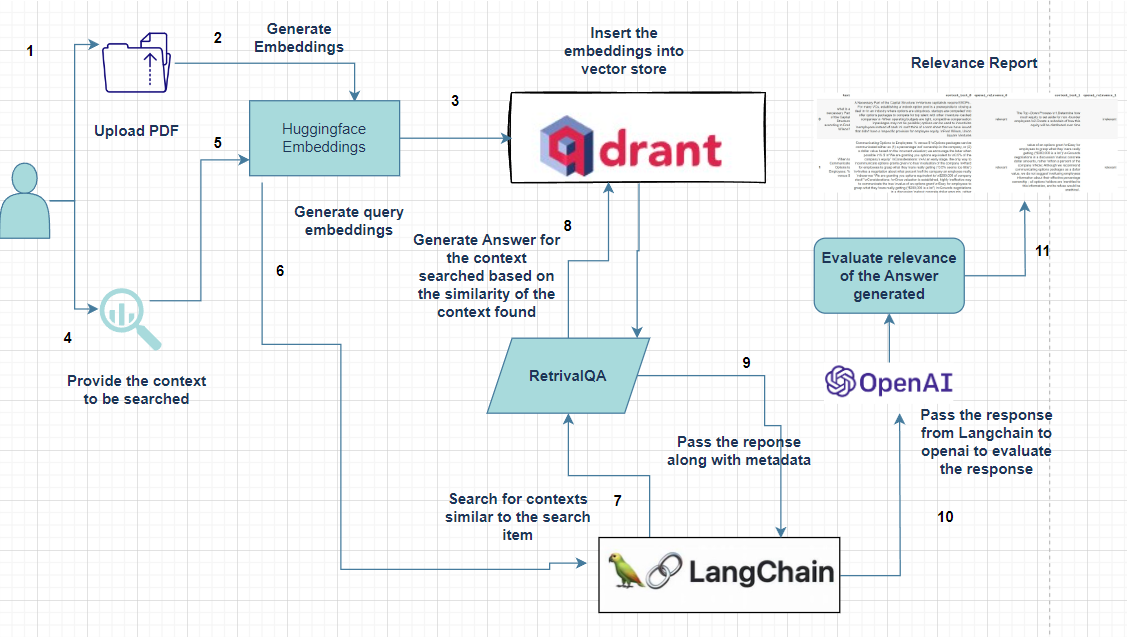

## INFERENCE - Using Retrieval Q&A in Langchain- RAG(Retrieval Augmented Generation)

In [68]:
from qdrant_client import models, QdrantClient
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores.qdrant import Qdrant
import PyPDF2
from PyPDF2 import PdfReader
from tqdm.auto import tqdm
from uuid import uuid4
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
import numpy as np
import pandas as pd
from time import time,sleep
import openai
from langchain import VectorDBQA
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
#
import os
import json
#
import io
import pytesseract
import shutil
import random
from PIL import Image
from pdf2image import convert_from_path
from configparser import ConfigParser
#
from typing import Dict, List, Optional, Tuple
from langchain.docstore.document import Document
from langchain.vectorstores import Qdrant
import pandas as pd
import numpy as np
#

ai_for_world_config = ConfigParser()

#
def read_config(parser: ConfigParser, location: str) -> None:
    assert parser.read(location), f"Could not read config {location}"
#
def get_scores(sentence1,sentence2,smodel):
  # encode sentences to get their embeddings
  embedding1 = smodel.encode(sentence1, convert_to_tensor=True)
  embedding2 = smodel.encode(sentence2, convert_to_tensor=True)
  # compute similarity scores of two embeddings
  cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
  return cosine_scores.numpy().tolist()[0][0]
#
def is_scanned_pdf(file_path):
    page_num  = []
    page_content = []
    pdf_reader = PdfReader(file_path)
    text = ""
    for i,page in enumerate(pdf_reader.pages):
      page_num.append(f"Page{i+1}")
      page_content.append(page.extract_text())
      text += page.extract_text()

    # if no text found, it is likely a scanned pdf
    if text == "":
        print("Scanned PDF")
        return True,page_num,page_content

    else:
        print("Text-based PDF")
        return False,page_num,page_content
#
#
def convert_pdf_to_image(pdf_path):
    pages = convert_from_path(pdf_path, 350)
    #
    output_dir="pdf_img_dir"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    i = 1
    for page in pages:
        image_name = "Page_" + str(i) + ".jpg"
        image_path = os.path.join(output_dir,image_name)
        page.save(image_path, "JPEG")
        i = i+1
    return output_dir

# Extract text from image
#
def extract_text_from_image(image_path):
    extractedInformation = pytesseract.image_to_string(Image.open(image_path))
    return extractedInformation
#
#
def get_text_chunks(text):
    text_splitter = RecursiveCharacterTextSplitter(
                            chunk_size=1000,
                            chunk_overlap=200,
                            separators=["\n\n", "\n", " ", ""]
                            )
    chunks = text_splitter.split_text(text)
    return chunks
#
def preprocess_function(request_data,content_type=None):
  pdf_docs = request_data["pdf1"]
  prompt = request_data["query"]
  flag,page_num,page_content = is_scanned_pdf(pdf_docs)
  pdf_name = "temppdf"
  f_path = os.path.join("/tmp", pdf_name)
  #
  print(pdf_docs)
  if flag:
    with open(f_path, "wb") as f:
        f.write(pdf_docs.getbuffer())
    print(f"filesize : {os.path.getsize(f_path)}")
    page_num  = []
    page_content = []
    text = ""
    # convert pdf to image
    image_dir = convert_pdf_to_image(f_path)
    for i,file in enumerate(os.listdir(image_dir)):
      page_num.append(f"Page{i+1}")
      image_path = os.path.join(image_dir,file)
      text += extract_text_from_image(image_path)
      page_content.append(extract_text_from_image(image_path))

      print(f"Text read from image: {text}")
  #
  metadatas = []
  texts = []
  for p,record in tqdm(zip(page_num,page_content)):
        # first get metadata fields for this record
        metadata = {'page number': p}
        # now we create chunks from the record text
        record_texts = get_text_chunks(record)
        # create individual metadata dicts for each chunk
        record_metadatas = [{
            "chunk": j, "text": text, **metadata
        } for j, text in enumerate(record_texts)]
        # append these to current batches
        texts.extend(record_texts)
        metadatas.extend(record_metadatas)
  c = []
  for i in range(len(metadatas)):
    c.append(metadatas[i]['text'])

  page_content = c
  return (flag,page_num,page_content,metadatas,prompt)
#
def model_load_function(model_path):
  embeddings = HuggingFaceEmbeddings(model_kwargs = {'device': 'cpu'},
                                    encode_kwargs = {'normalize_embeddings': False})
  smodel = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
  #
  return (embeddings,model_path,smodel)
#
def predict_function(context,model,content_type=None):
  embeddings,model_path,smodel= model
  flag,page_num,page_content,metadatas,prompt = context
  #Read config file for openai api key
  #
  '''
  CONFIG_FILE = os.path.join(model_path, "env.conf")
  read_config(ai_for_world_config, CONFIG_FILE)
  api_key = ai_for_world_config.get("openai", "api_key").strip()
  #define llm
  '''
  #
  llm = OpenAI(openai_api_key=os.environ["OPENAI_API_KEY"],temperature=0)
  #create vector store
  #

  doc_store = Qdrant.from_texts(page_content,
                              metadatas=metadatas,
                              embedding=embeddings,
                              location=":memory:",
                              prefer_grpc=True,

                              collection="doc_search")

  #query vector store
  prompt_template = """Use the following pieces of context to answer the question enclosed within  3 backticks at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.
  Please provide an answer which is factually correct and based on the information retrieved from the vector store.
  Please also mention any quotes supporting the answer if any present in the context supplied within two double quotes "" .

{context}

QUESTION:```{question}```
ANSWER:
  """
  PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context","question"]
  )
  #
  chain_type_kwargs = {"prompt": PROMPT}
  '''
  qa = RetrievalQA.from_chain_type(llm=OpenAI(),
                                   chain_type="stuff",
                                   retriever=docsearch.as_retriever(),
                                   return_source_documents=True)


  '''
  #get scores
  #similar_items = doc_store.similarity_search_with_relevance_scores(prompt)
  #print(similar_items)
  #
  qa = RetrievalQA.from_chain_type(llm=ChatOpenAI(model_name='gpt-3.5-turbo-16k',
                                                  openai_api_key=os.environ["OPENAI_API_KEY"],
                                                  temperature=0),
                                  chain_type="stuff",
                                  chain_type_kwargs={"prompt": PROMPT},
                                  retriever=doc_store.as_retriever(search_kwargs={"k": 5}),
                                      return_source_documents=True
                                  )



  # Serach for answer
  print(prompt)
  final_result = []
  for pmpt in prompt:
    result = qa(pmpt)
    final_result.append(result)
  return (final_result,smodel,context,embeddings)
#
def postprocess_function(res, content_type=None):
  results,smodel,context,embeddings = res
  flag,page_num,page_content,metadatas,prompt = context
  #
  queries =[]
  answers = []
  final_ref = []
  final_pages = []
  final_scores = []
  for result in results :
    query = result['query']
    answer = result['result']
    queries.append(query)
    answers.append(answer)
    referrences = []
    pages = []
    scores = []
    #
    for i in range(len(result["source_documents"])):
      print(f"Content : {result['source_documents'][i].page_content}")
      referrences.append(result['source_documents'][i].page_content)
      print(f"Page Number : {result['source_documents'][i].metadata['page number']}")
      pages.append(result['source_documents'][i].metadata['page number'])

    final_ref.append(referrences)
    final_pages.append(pages)
    # Get the similarity scores for the documents selected

    for item in referrences:
      scores.append(get_scores(query,item,smodel))
    final_scores.append(scores)
  # Format the response
  predictions = {"Query":queries,
                 "Answer":answers,
                 "Referrences":final_ref,
                 "Page Numbers":final_pages,
                 "Scores": final_scores}
  #Generate Database dataframe
  t = []
  e = []
  for ts in page_content:
    t.append(ts)
    e.append(embeddings.embed_documents(ts)[0])
  database_df = pd.DataFrame({"text":t,"text_vector":e})
  #database_df.to_parquet("database_df.parquet",index=False)
  #processing quer_df attributes
  txt = []
  text_vector = []
  response = []
  context_text_0 = []
  context_text_1 = []
  context_similarity_0 = []
  context_similarity_1 = []
  user_feedback = []

  for q,a,refs,scrs in zip(queries,answers,final_ref,final_scores):
    txt.append(q)
    text_vector.append(embeddings.embed_query(q))
    response.append(a)
    context_text_0.append(refs[0])
    context_text_1.append(refs[1])
    context_similarity_0.append(scrs[0])
    context_similarity_1.append(scrs[1])
    user_feedback.append(1.0)
  #Create query dataframe based on the response received
  query_df = pd.DataFrame({"text":txt,
                           "text_vector":text_vector,
                           "response":response,
                           "context_text_0":context_text_0,
                           "context_text_1":context_text_1,
                           "context_similarity_0":context_similarity_0,
                           "context_similarity_1":context_similarity_1,
                           "user_feedback":user_feedback})
  # delete temp directories if any created
  output_dir="pdf_img_dir"
  if os.path.exists(output_dir):
    for  file in os.listdir(output_dir):
      file_name = os.path.join(output_dir,file)
      if os.path.exists(file_name) and os.path.isfile(file_name):
        print(f"File {file_name} exists. Hence Removing")
        os.remove(file_name)
  return (predictions,database_df,query_df)


## Data Preprocessing

In [69]:
%%time
from langchain import PromptTemplate
from sentence_transformers import SentenceTransformer, util

request_data = {"pdf1":"/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf",
                "query":["what is a neccessary Part of the Capital Structure according to Fred Wilson?",
                         "When to Communicate Options to Employees: % versus $",
                         "When to Create an ESOP?",
                         "What are the Common Terms in an Options Package?"]}
content = preprocess_function(request_data,content_type=None)

Text-based PDF
/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf


0it [00:00, ?it/s]

CPU times: user 1.49 s, sys: 7.88 ms, total: 1.5 s
Wall time: 1.52 s


## Load The Model

In [70]:
%%time
model = model_load_function(model_path=None)


CPU times: user 2.3 s, sys: 1.93 s, total: 4.22 s
Wall time: 8.65 s


## Invoke Predictions

In [71]:
%%time
response = predict_function(content,model,content_type=None)

['what is a neccessary Part of the Capital Structure according to Fred Wilson?', 'When to Communicate Options to Employees: % versus $', 'When to Create an ESOP?', 'What are the Common Terms in an Options Package?']
CPU times: user 51.5 s, sys: 8.22 s, total: 59.7 s
Wall time: 1min 11s


In [72]:
response

([{'query': 'what is a neccessary Part of the Capital Structure according to Fred Wilson?',
   'result': 'According to Fred Wilson, a necessary part of the capital structure is employee equity or ESOPs (Employee Stock Ownership Plans). He states, "I can\'t think of a term sheet that we have issued that didn\'t have a specific provision for employee equity." This suggests that offering employee equity is a prerequisite for venture capitalists and is commonly included in deals with startups.',
   'source_documents': [Document(page_content="A Necessary Part of the Capital Structure  \n•Venture capitalists require ESOPs . For many VCs, establishing a \nstock option pool is a prerequisite to closing a deal  \n–In an industry where options are ubiquitous, startups are compelled \nto offer options packages to compete for top talent with other \nventure -backed companies  \n–When operating budgets are tight, competitive compensation \npackages may not be possible; options can be used to incent

## Format the response generated

In [73]:
%%time
out = postprocess_function(response, content_type=None)

Content : A Necessary Part of the Capital Structure  
•Venture capitalists require ESOPs . For many VCs, establishing a 
stock option pool is a prerequisite to closing a deal  
–In an industry where options are ubiquitous, startups are compelled 
to offer options packages to compete for top talent with other 
venture -backed companies  
–When operating budgets are tight, competitive compensation 
packages may not be possible; options can be used to incentivize 
employees instead of cash  
I can't think of a term sheet that we have issued that didn't have a 
specific provision for employee equity.  
Fred Wilson, Union Square Ventures
Page Number : Page10
Content : The Top -Down Process  
1.Determine how much equity to set aside for non -founder employees  
2.Create a schedule of how this equity will be distributed over time
Page Number : Page15
Content : Resources & Further Reading  
•Fred Wilson / Union Square Ventures Series on Employee Equity  
–What are options?  
–Structures and al

#### The columns of the responsew dataframe are:

- text: the query text
- text_vector: the embedding representation of the query, captured from LangChain at query time
- response: the final response from the LangChain application
- context_text_0: the first retrieved context from the knowledge base
- context_similarity_0: the cosine similarity between the query and the first retrieved context
- context_text_1: the second retrieved context from the knowledge base
- context_similarity_1: the cosine similarity between the query and the first retrieved context
- user_feedback: approval or rejection from the user (-1 means thumbs down, +1 means thumbs up)

In [74]:
predictions,database_df,query_df = out

In [75]:
print(predictions)

{'Query': ['what is a neccessary Part of the Capital Structure according to Fred Wilson?', 'When to Communicate Options to Employees: % versus $', 'When to Create an ESOP?', 'What are the Common Terms in an Options Package?'], 'Answer': ['According to Fred Wilson, a necessary part of the capital structure is employee equity or ESOPs (Employee Stock Ownership Plans). He states, "I can\'t think of a term sheet that we have issued that didn\'t have a specific provision for employee equity." This suggests that offering employee equity is a prerequisite for venture capitalists and is commonly included in deals with startups.', 'The context does not provide information about when to communicate options to employees as a percentage versus a dollar value.', 'ESOPs should be created during the seed stage or early-VC stage of a startup.', 'The common terms in an options package are:\n1. Number of Shares: The total number of options granted to an employee, and the maximum number of shares that em

https://towardsdatascience.com/semantic-similarity-using-transformers-8f3cb5bf66d6

## Sample text to compute cosine similarity

In [ ]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

In [ ]:
smodel = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [ ]:
def scores(sentence1,sentence2):
  # encode sentences to get their embeddings
  embedding1 = smodel.encode(sentence1, convert_to_tensor=True)
  embedding2 = smodel.encode(sentence2, convert_to_tensor=True)
  # compute similarity scores of two embeddings
  cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
  return cosine_scores.numpy().tolist()[0][0]

In [ ]:
txt1 = "what is a neccessary Part of the Capital Structure according to Fred Wilson?"
txt2 = """A Necessary Part of the Capital Structure
•Venture capitalists require ESOPs . For many VCs, establishing a
stock option pool is a prerequisite to closing a deal
–In an industry where options are ubiquitous, startups are compelled
to offer options packages to compete for top talent with other
venture -backed companies
–When operating budgets are tight, competitive compensation
packages may not be possible; options can be used to incentivize
employees instead of cash
I can't think of a term sheet that we have issued that didn't have a
specific provision for employee equity.
Fred Wilson, Union Square Ventures
Page Number : Page10
Content : The Top -Down Process
1.Determine how much equity to set aside for non -founder employees
2.Create a schedule of how this equity will be distributed over time"""

In [ ]:
scores(txt1,txt2)

0.47183188796043396

In [ ]:
scores(txt1,txt2).numel()

1

## Display Returned DataFrames

In [93]:
pd.set_option("display.max_colwidth", 50)

In [94]:
database_df.head()

,text,text_vector,centered_text_vector
0,Startup Employee Stock \nOptions Plans (ESOPs)...,"[0.0003137296298518777, 0.008552555926144123, ...","[0.0006470922112281248, 0.00888591850752037, -..."
1,Table of Contents \nPart I: Intro to Options ...,"[-0.023618347942829132, -0.06379010528326035, ...","[-0.023495769524682058, -0.06366752686511327, ..."
2,•Important Takeaways Part III : The Fine Prin...,"[-0.018981635570526123, 0.03906095772981644, -...","[-0.01897012570371215, 0.03907246759663041, -0..."
3,INTRO TO OPTIONS PLANS Part I,"[0.011805826798081398, 0.048538338392972946, -...","[0.012143419000686384, 0.04887593059557793, -0..."
4,What is an ESOP? \n•An Employee Stock Options...,"[-0.030949262902140617, 0.045493677258491516, ...","[-0.030975572079112945, 0.04546736808151919, 0..."


In [42]:
database_df.tail()

,text,text_vector
45,"Year 2 Hires\nSales Director $70,000 0.30x $21...","[0.019291622564196587, 0.0583992600440979, 0.0..."
46,RESOURCES & FURTHER \nREADING Part V,"[-0.0035545711871236563, -0.032489269971847534..."
47,Resources & Further Reading \n•Fred Wilson / ...,"[-0.0035545711871236563, -0.032489269971847534..."
48,Resources & Further Reading \n•Andy Rachleff ...,"[-0.0035545711871236563, -0.032489269971847534..."
49,This work is licensed under the Creative C...,"[-0.023618347942829132, -0.06379010528326035, ..."


In [40]:
database_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         50 non-null     object
 1   text_vector  50 non-null     object
dtypes: object(2)
memory usage: 928.0+ bytes


In [95]:
query_df.head()

,text,text_vector,response,context_text_0,context_text_1,context_similarity_0,context_similarity_1,user_feedback,centered_text_vector
0,what is a neccessary Part of the Capital Struc...,"[0.018048636615276337, 0.004823092371225357, -...","According to Fred Wilson, a necessary part of ...",A Necessary Part of the Capital Structure \n•...,The Top -Down Process \n1.Determine how much ...,0.491406,0.456906,1.0,"[0.01806583090046247, 0.0048402866564114895, -..."
1,When to Communicate Options to Employees: % ve...,"[0.021837031468749046, 0.016419939696788788, -...",The context does not provide information about...,Communicating Options to Employees: % versus $...,value of an options grant \n•Easy for employe...,0.754257,0.569296,1.0,"[0.021674202866316567, 0.01625711109435631, -0..."
2,When to Create an ESOP?,"[0.0076230671256780624, -0.02172561176121235, ...",ESOPs should be created during the seed stage ...,When to Create an ESOP? \nStage Consideratio...,"Two Approaches \nIn reality, creating an ESOP...",0.738180,0.700007,1.0,"[0.007500557095284817, -0.021848121791605595, ..."
3,What are the Common Terms in an Options Package?,"[-0.023321891203522682, -0.1582910716533661, -...",The common terms in an options package are:\n1...,Common Terms in an Options Package \nNumber o...,Appropriate use of these securities will \nvar...,0.664095,0.576239,1.0,"[-0.02312235172527599, -0.1580915321751194, 8...."


In [78]:
query_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text                  4 non-null      object 
 1   text_vector           4 non-null      object 
 2   response              4 non-null      object 
 3   context_text_0        4 non-null      object 
 4   context_text_1        4 non-null      object 
 5   context_similarity_0  4 non-null      float64
 6   context_similarity_1  4 non-null      float64
 7   user_feedback         4 non-null      float64
dtypes: float64(3), object(5)
memory usage: 384.0+ bytes


In [32]:
database_df = pd.read_parquet(
    "http://storage.googleapis.com/arize-assets/phoenix/datasets/unstructured/llm/context-retrieval/langchain-pinecone/database.parquet"
)
database_df.head()

,text,text_vector
0,\nAccess tutorials of what's possible with Ari...,"[-0.0036313518733896957, 0.0026182831234325553..."
1,"\n{% hint style=""info"" %}\nYour model type det...","[-0.006279695251247202, -0.0005314257337369415..."
2,\nExamples for logging explainability metrics....,"[-0.007306394403318994, 0.0007199545863166625,..."
3,\n| Google Cloud Services | Link |\n| ------...,"[0.002060703379662884, -0.0037287262540240764,..."
4,\n| Sending 10 Million Inferences to Arize in ...,"[-0.008325811390756237, -0.008001045242455413,..."


In [33]:
database_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086 entries, 0 to 1085
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         1086 non-null   object
 1   text_vector  1086 non-null   object
dtypes: object(2)
memory usage: 17.1+ KB


In [34]:

query_df = pd.read_parquet(
    "http://storage.googleapis.com/arize-assets/phoenix/datasets/unstructured/llm/context-retrieval/langchain-pinecone/langchain_pinecone_query_dataframe_with_user_feedbackv2.parquet"
)
query_df.head()

,text,text_vector,response,context_text_0,context_text_1,context_similarity_0,context_similarity_1,user_feedback
0,How do I use the SDK to upload a ranking model?,"[-0.009508815594017506, 0.008546245284378529, ...","To use the SDK to upload a ranking model, you ...",\n**Check out our** **How to Monitor Ranking M...,"\n**Use the 'arize-demo-hotel-ranking' model, ...",0.827150,0.819964,-1.0
1,What drift metrics are supported in Arize?,"[-0.009323584847152233, -0.0005137172411195934...",Arize supports several drift metrics including...,\nArize calculates drift metrics such as Popul...,"\nDrift monitors measure distribution drift, w...",0.886113,0.884156,NaN
2,Does Arize support batch models?,"[-0.016475794836878777, -0.0009410726488567889...","Yes, Arize supports batch models as long as th...",\nArize supports many model types - check out ...,\nArize natively supports binary classificatio...,0.870960,0.856241,-1.0
3,Does Arize support training data?,"[-0.02083049900829792, -0.008836966007947922, ...",Arize is primarily a platform for model perfor...,\nArize natively supports binary classificatio...,\nArize natively supports tabular/structured d...,0.869958,0.865478,-1.0
4,How do I configure a threshold if my data has ...,"[-0.0008055078214965761, -0.011270225048065186...","If your data has seasonality trends, you may w...",\nAutomatic thresholds set a dynamic threshold...,\nAutothresholds are calculated based on a sta...,0.831995,0.823832,-1.0


In [36]:
query_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153 entries, 0 to 152
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text                  153 non-null    object 
 1   text_vector           153 non-null    object 
 2   response              153 non-null    object 
 3   context_text_0        153 non-null    object 
 4   context_text_1        153 non-null    object 
 5   context_similarity_0  153 non-null    float64
 6   context_similarity_1  153 non-null    float64
 7   user_feedback         83 non-null     float64
dtypes: float64(3), object(5)
memory usage: 10.8+ KB


## Model Evaluation using GPT4

In [79]:
cen =[]
c_text_vector =[]
for items in  database_df["text_vector"].values:
  cen.append(np.mean(items))
  c_text_vector.append(items - np.mean(items))



In [80]:
len(cen),len(c_text_vector)

(50, 50)

In [81]:
len(c_text_vector[0])

768

In [96]:
database_df["centered_text_vector"]  = c_text_vector
database_df.head()

,text,text_vector,centered_text_vector
0,Startup Employee Stock \nOptions Plans (ESOPs)...,"[0.0003137296298518777, 0.008552555926144123, ...","[0.0006470922112281248, 0.00888591850752037, -..."
1,Table of Contents \nPart I: Intro to Options ...,"[-0.023618347942829132, -0.06379010528326035, ...","[-0.023495769524682058, -0.06366752686511327, ..."
2,•Important Takeaways Part III : The Fine Prin...,"[-0.018981635570526123, 0.03906095772981644, -...","[-0.01897012570371215, 0.03907246759663041, -0..."
3,INTRO TO OPTIONS PLANS Part I,"[0.011805826798081398, 0.048538338392972946, -...","[0.012143419000686384, 0.04887593059557793, -0..."
4,What is an ESOP? \n•An Employee Stock Options...,"[-0.030949262902140617, 0.045493677258491516, ...","[-0.030975572079112945, 0.04546736808151919, 0..."


In [83]:
qcen =[]
qc_text_vector =[]
for items in  query_df["text_vector"].values:
  qcen.append(np.mean(items))
  qc_text_vector.append(items - np.mean(items))

In [84]:
len(qcen),len(qc_text_vector),len(qc_text_vector[0])

(4, 4, 768)

In [85]:
query_df["centered_text_vector"] = qc_text_vector

In [97]:
query_df.head()

,text,text_vector,response,context_text_0,context_text_1,context_similarity_0,context_similarity_1,user_feedback,centered_text_vector
0,what is a neccessary Part of the Capital Struc...,"[0.018048636615276337, 0.004823092371225357, -...","According to Fred Wilson, a necessary part of ...",A Necessary Part of the Capital Structure \n•...,The Top -Down Process \n1.Determine how much ...,0.491406,0.456906,1.0,"[0.01806583090046247, 0.0048402866564114895, -..."
1,When to Communicate Options to Employees: % ve...,"[0.021837031468749046, 0.016419939696788788, -...",The context does not provide information about...,Communicating Options to Employees: % versus $...,value of an options grant \n•Easy for employe...,0.754257,0.569296,1.0,"[0.021674202866316567, 0.01625711109435631, -0..."
2,When to Create an ESOP?,"[0.0076230671256780624, -0.02172561176121235, ...",ESOPs should be created during the seed stage ...,When to Create an ESOP? \nStage Consideratio...,"Two Approaches \nIn reality, creating an ESOP...",0.738180,0.700007,1.0,"[0.007500557095284817, -0.021848121791605595, ..."
3,What are the Common Terms in an Options Package?,"[-0.023321891203522682, -0.1582910716533661, -...",The common terms in an options package are:\n1...,Common Terms in an Options Package \nNumber o...,Appropriate use of these securities will \nvar...,0.664095,0.576239,1.0,"[-0.02312235172527599, -0.1580915321751194, 8...."


## Gauge the relevance of the contexts based on the questions asked as evaluated by GPT4

In [89]:
import os
import textwrap
from datetime import timedelta
from typing import Dict, List, Optional, Tuple
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)
from tqdm import tqdm

pd.set_option("display.max_colwidth", None)
#
EVALUATION_SYSTEM_MESSAGE = "You will be given a query and a reference text. You must determine whether the reference text contains an answer to the input query. Your response must be binary (0 or 1) and should not contain any text or characters aside from 0 or 1. 0 means that the reference text does not contain an answer to the query. 1 means the reference text contains an answer to the query."
QUERY_CONTEXT_PROMPT_TEMPLATE = """# Query: {query}

# Reference: {reference}

# Binary: """

openai.api_key = os.environ["OPENAI_API_KEY"]
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def evaluate_query_and_retrieved_context(query: str, context: str, model_name: str) -> str:
    prompt = QUERY_CONTEXT_PROMPT_TEMPLATE.format(
        query=query,
        reference=context,
    )
    response = openai.ChatCompletion.create(
        messages=[
            {"role": "system", "content": EVALUATION_SYSTEM_MESSAGE},
            {"role": "user", "content": prompt},
        ],
        model=model_name,
    )
    return response["choices"][0]["message"]["content"]


def evaluate_retrievals(
    retrievals_data: Dict[str, str],
    model_name: str,
) -> List[str]:
    responses = []
    for query, retrieved_context in tqdm(retrievals_data.items()):
        response = evaluate_query_and_retrieved_context(query, retrieved_context, model_name)
        responses.append(response)
    return responses


def process_binary_responses(
    binary_responses: List[str], binary_to_string_map: Dict[int, str]
) -> List[str]:
    """
    Parse binary responses and convert to the desired format
    converts them to the desired format. The binary_to_string_map parameter
    should be a dictionary mapping binary values (0 or 1) to the desired
    string values (e.g. "irrelevant" or "relevant").
    """
    processed_responses = []
    for binary_response in binary_responses:
        try:
            binary_value = int(binary_response.strip())
            processed_response = binary_to_string_map[binary_value]
        except (ValueError, KeyError):
            processed_response = None
        processed_responses.append(processed_response)
    return processed_responses


sample_query_df = query_df.head(10).copy()
evaluation_model_name = "gpt-3.5-turbo"  # use GPT-4 if you have access
for context_index in range(2):
    retrievals_data = {
        row["text"]: row[f"context_text_{context_index}"] for _, row in sample_query_df.iterrows()
    }
    raw_responses = evaluate_retrievals(retrievals_data, evaluation_model_name)
    processed_responses = process_binary_responses(raw_responses, {0: "irrelevant", 1: "relevant"})
    sample_query_df[f"openai_relevance_{context_index}"] = processed_responses
sample_query_df[
    ["text", "context_text_0", "openai_relevance_0", "context_text_1", "openai_relevance_1"]
].head(10)

100%|██████████| 4/4 [00:01<00:00,  2.22it/s]


,text,context_text_0,openai_relevance_0,context_text_1,openai_relevance_1
0,what is a neccessary Part of the Capital Structure according to Fred Wilson?,"A Necessary Part of the Capital Structure \n•Venture capitalists require ESOPs . For many VCs, establishing a \nstock option pool is a prerequisite to closing a deal \n–In an industry where options are ubiquitous, startups are compelled \nto offer options packages to compete for top talent with other \nventure -backed companies \n–When operating budgets are tight, competitive compensation \npackages may not be possible; options can be used to incentivize \nemployees instead of cash \nI can't think of a term sheet that we have issued that didn't have a \nspecific provision for employee equity. \nFred Wilson, Union Square Ventures",relevant,The Top -Down Process \n1.Determine how much equity to set aside for non -founder employees \n2.Create a schedule of how this equity will be distributed over time,irrelevant
1,When to Communicate Options to Employees: % versus $,"Communicating Options to Employees: % versus $ \nOptions packages can be communicated either as (1) a percentage \nof ownership in the company, or (2) a dollar value based on the \ncurrent valuation; we encourage the latter when possible \n% $ \n“We are granting you options equivalent to \n0.5% of the company’s equity” \nConsiderations: \n•At an early stage, the only way to \ncommunicate options grants given no true \nvaluation of the company \n•Hard for employees to grasp what they \nare really getting (“0.5% seems too little”) \n•Invites a negotiation about what percent \nof the company an employee really \ndeserves “We are granting you options equivalent to \n$200,000 of company stock” \nConsiderations: \n•Once valuation is established, highly \neffective way to communicate the true \nvalue of an options grant \n•Easy for employees to grasp what they \nare really getting (“$200,000 is a lot”) \n•Grounds negotiations in a discussion \nabout concrete dollar amounts, rather",relevant,"value of an options grant \n•Easy for employees to grasp what they \nare really getting (“$200,000 is a lot”) \n•Grounds negotiations in a discussion \nabout concrete dollar amounts, rather \nthan a percent of the company \nNote: Although we recommend communicating options packages as a dollar value, we do not suggest \nrefusing employees information about their effective percentage ownership ; all options holders are \nentitled to this information, and to refuse would be unethical .",relevant
2,When to Create an ESOP?,"When to Create an ESOP? \nStage Considerations Takeaway \nPre-seed Founders focused on traction (often too \nbusy for an ESOP). Key employees are \ngiven equity/options on an ad hoc basis ESOP not necessary, but it can be \nhelpful to sanity check how much equity \nyou are giving away to early hires \nSeed First outside financing round. Investors \neither angel or institutional; institutional \ninvestors will require an ESOP Seed rounds can be closed without an \nESOP; the benefit to doing so is that \nseed investors then share in the dilution \nEarly -VC The first true VC round. Investors will \nrequire an ESOP in place. New hires \nwill be seek large equity grants. ESOP must be created (to appease \ninvestors and to serve as a guideline for \nthe size of new -hire options grants) \nLate-VC Flush with capital, startups at this stage \nbegin to steadily ramp -up hiring, yet \nemployees still want equity Important to have standardized the \nESOP and the amount of equity granted",relevant,"Two Approaches \nIn reality, creating an ESOP will require a combination of \ntop-down and bottom -up planning Top Down Bottom Up \nDecide the total amount of \nequity to be granted; allocate \nthese shares to employees \nover time Decide the appropriate size of \nindividual equity grants by \nposition; issue these shares as \nemployees are hired",relevant
3,What are the Common Terms in an Options Package?,"Common Terms in an Options Pa

In [98]:
sample_query_df[
    ["text", "context_text_0", "openai_relevance_0", "context_text_1", "openai_relevance_1"]
].head(10)

,text,context_text_0,openai_relevance_0,context_text_1,openai_relevance_1
0,what is a neccessary Part of the Capital Struc...,A Necessary Part of the Capital Structure \n•...,relevant,The Top -Down Process \n1.Determine how much ...,irrelevant
1,When to Communicate Options to Employees: % ve...,Communicating Options to Employees: % versus $...,relevant,value of an options grant \n•Easy for employe...,relevant
2,When to Create an ESOP?,When to Create an ESOP? \nStage Consideratio...,relevant,"Two Approaches \nIn reality, creating an ESOP...",relevant
3,What are the Common Terms in an Options Package?,Common Terms in an Options Package \nNumber o...,relevant,Appropriate use of these securities will \nvar...,irrelevant


In [ ]:
openai_evaluations_df = pd.read_parquet(
    "http://storage.googleapis.com/arize-assets/phoenix/datasets/unstructured/llm/context-retrieval/langchain-pinecone/langchain_pinecone_openai_evaluations.parquet",
)[["text", "openai_relevance_0", "openai_relevance_1"]]
query_df = pd.merge(query_df, openai_evaluations_df, on="text")
query_df[["text", "context_text_0", "context_text_1", "openai_relevance_0", "openai_relevance_1"]]

,text,context_text_0,context_text_1,openai_relevance_0,openai_relevance_1
0,How do I use the SDK to upload a ranking model?,\n**Check out our** **How to Monitor Ranking Model's** **blog and follow along with our various** **Colab** **examples here.**&#x20;\n\n,"\n**Use the 'arize-demo-hotel-ranking' model, available in all free accounts, to follow along.**&#x20;\n\n",irrelevant,irrelevant
1,What drift metrics are supported in Arize?,"\nArize calculates drift metrics such as Population Stability Index, KL Divergence, and Wasserstein Distance. Arize computes drift by measuring distribution changes between the model’s production values and a baseline (reference dataset). Users can configure a baseline to be any time window of a:\n\n1. Pre-production dataset (training, test, validation) or\n2. Fixed or moving time period from production (e.g. last 30 days, last 60 days).&#x20;\n\nBaselines are saved in Arize so that users can compare several versions and/or environments against each other across moving or fixed time windows. For more details on baselines, visit here.\n\n","\nDrift monitors measure distribution drift, which is the difference between two statistical distributions.&#x20;\n\nArize offers various distributional drift metrics to choose from when setting up a monitor. Each metric is tailored to a specific use case; refer to this guide to help choose the appropriate metric for various ML use cases.\n\n",relevant,irrelevant
2,Does Arize support batch models?,\nArize supports many model types - check out our various Model Types to learn more.&#x20;\n\n,"\nArize natively supports binary classification, multi-class classification, regression, ranking, NLP, and CV model types. Your model type informs the **data ingestion format** and **the performance metrics** that can be utilized in the platform.&#x20;\n\n",irrelevant,irrelevant
3,Does Arize support training data?,"\nArize natively supports binary classification, multi-class classification, regression, ranking, NLP, and CV model types. Your model type informs the **data ingestion format** and **the performance metrics** that can be utilized in the platform.&#x20;\n\n","\nArize natively supports tabular/structured data types (strings, floats, booleans, etc), as well as embedding support for NLP, Image, and other unstructured data types.\n\n",irrelevant,irrelevant
4,How do I configure a threshold if my data has seasonality trends?,\nAutomatic thresholds set a dynamic threshold value for each data point. Arize generates an auto threshold when there are at least 14 days of production data to determine a trend. You can edit your auto threshold sensitivity by changing the standard deviation number in the 'Monitor Settings' card.&#x20;\n\nLearn more here about how an auto threshold value is calculated.&#x20;\n\nAuto Threshold\n\nToggle automatic thresholds on or off from the “Edit monitor” configuration.\n\n,"\nAutothresholds are calculated based on a statistical analysis of data over 14 days. Each day, a data point is collected, and after 14 days, the average (mean) and standard deviation of these data points are computed. The thresholds is then set by adding or subtracting the standard deviation from the average.\n\n",irrelevant,irrelevant
...,...,...,...,...,...
148,Do you support IoU for image segmentation?,\nArize supports 2 methods for ingesting and visualizing feature importance\n\nMethodUser Calculated SHAPshap.mdimage (33).pngGroup 1 (2).pngSurrogate Modelsurrogate-model.mdimage (23).pngGroup 2 (2).png\n\n\n\n,"\nObject detection models identify and locate objects within images or videos by assigning them specific bounding boxes.\n\nApplicable Metrics: Accuracy, Euclidian Distance (embeddings)\n\nClick here for all valid model types and metric combinations.&#x20;\n\n",irrelevant,irrelevant
149,This is a test question?,"\nIn the example above, there wasn't enough context on video quality to be able to correctly answer the user questions. Adding more context can help.&#x20;\